# File Preprocessing

In [ ]:
# jupyter/base-notebook 이미지 사용
# 호스트의 디렉토리에 있는 eHealthPython 프로젝트를 컨테이너 볼륨에 마운트
# docker run -d -p 8888:8888 -v /Users/jonghyunlim/Workspace/eHealthPython:/home/jovyan/work --name eHealth_jupyter jupyter/base-notebook
# docker ps로 컨테이너 ID 확인하고
# docker logs 컨테이너 ID로 인증 토큰 확인

!pip install pandas
# pandas에 numpy 포함
#!pip install numpy
!pip install matplotlib
!pip install chardet
!pip install scipy
!pip install sympy
!pip install phe

In [1]:
# MiBand에서 추출한 데이터를 Excel을 통해 모두 csv, UTF-8로 저장할 것
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import chardet #check file encoding

# Laplace Mechanism
from scipy.stats import laplace
from scipy.stats import gamma
from sympy import Symbol, exp, sqrt, pi, Integral
import math

# Paillier Homomorphic Encryption
import phe
from phe import paillier

# MongoDB
# import pymongo
# from pymongo import MongoClient

# Log 남기기
from datetime import datetime
import time

print('Import Complete')

Import Complete


In [3]:
# 디렉토리 내의 csv 파일(걸음수 데이터)을 모두 가져와 리스트에 담는다
def get_file_list(dirname):
    f_list = []
    for (path, dir, files) in os.walk(dirname):
        for filename in files:
            ext = os.path.splitext(filename)[-1]
            if ext == '.csv' or ext =='.xls':
                f_list.append(os.path.join(path, filename))
    return f_list


# 파일의 인코딩 확인
def find_encoding(file):
    r_file = open(file, 'rb').read()
    result = chardet.detect(r_file)
    charenc = result['encoding']
    return charenc


# 라플라스 메커니즘으로 노이즈 추가
def lap_mechanism(original_data=[], loc=0, scale=0, N=0, sensitivity=0, epsilon=0, flag=0):
    def laprnd(loc,scale):
        s = laplace.rvs(loc, scale, None)
        return s
    
    if flag == 1:
        scale = sensitivity/epsilon
    if flag == 2:
        scale = (sensitivity/N)/(epsilon)
    scale = (sensitivity/N)/(epsilon)
    noisy_data = list(map(lambda i: i + laprnd(0, scale)/N, original_data))
    return list(np.around(np.array(noisy_data)))


# 라플라스 메커니즘의 infinite divisibility(무한 분할성)을 활용한 감마 분포의 실수 차를 노이즈로 추가
# test = 1 : 기본 감마 노이즈 생성
# test = 2 : 그룹별 사용자 나눠서 평균 도출 실험
def lap_mechanism_gamma(original_data=[], loc=0, scale=0, people_num=0, epsil=0, test=0):
    def gammarnd(shpae, scale):
        def two_gammarnd_diff1():
            r = gamma.rvs(eshape, eloc, escale, size=2)

        rnd_diff_list=[]

        for i in range(len(original_data)):
            r = gamma.rvs(shape, 0, scale, 2)
            rnd_diff_list.append(r[0]-r[1])
        return rnd_diff_list

#     slot_size = np.count_nonzero(~np.isnan(original_data))    #number of salient point
    
    N = people_num
    slot_size = 66    #number of time period
    sensitivity, epsilon = 7000, epsil
    if test is 1:
        shape,scale = 1/N, (sensitivity/N)/(epsilon/slot_size)
    elif test is 2:
        group = 6
        shape,scale = 1/N, (sensitivity/(N/group))/(epsilon/(slot_size/group))
    
    gamma_noise_list = gammarnd(shape, scale)
    noisy_data = np.array(original_data) + np.array(gamma_noise_list)
    return noisy_data


# Paillier - Homomorphic Encryption Scheme
# encrypt with public_key & decrypt with private_key
class Paillier:
    def __init__(self):
        self.pub_key = 0
        self.priv_key = 0
    
    def setKey(self, pub_key, priv_key):
        self.pub_key, self.priv_key = paillier.generate_paillier_keypair(n_length=2048)
        
    def enc(self, data_lst=[]):
        encrypted_data_lst = []
        for data in data_lst:
            encrypted_data_lst.append(self.pub_key.encrypt(data))
        return encrypted_data_lst
    
    def func_chk(self, data_lst=[]):
        print('original data sum :',np.around(sum(data_lst)), 'encrypted data sum :', np.around(self.priv_key.decrypt(sum(self.enc(data_lst)))))
        print('original data average :', np.around(sum(data_lst)/len(data_lst)), 'encrypted data average :', np.around(self.priv_key.decrypt(sum(self.enc(data_lst))/len(self.enc(data_lst)))))


def histogram_generate(df):
    all_day_histogram_original_dict = dict()
    all_day_histogram_noisy_dict = dict()
    hours=[10,11,12,13,14,15,16,17,18,19,20]

    for date in dates:
        hour_data = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        for row in df.itertuples(index=False, name='Pandas'):
            if getattr(row, 'Date')==date:
                hour_data[getattr(row, 'Hour')-10] += getattr(row, 'Steps')
    #     print(np.around(np.array(hour_data)/6))
        all_day_histogram_original_dict[date] = list(np.around(np.array(hour_data)/6))

    for date in dates:
        original_data = all_day_histogram_original_dict[date]
#         noisy_data = lap_mechanism(all_day_histogram_original_dict[date])
        noisy_data = lap_mechanism_gamma(all_day_histogram_original_dict[date], 0, 0, 443, 0.1, 1)        
        all_day_histogram_noisy_dict[date] = noisy_data
#         print(date)
#         print(original_data)
#         print(noisy_data)
    print(abs(all_day_histogram_original_dict[dates[0]] - all_day_histogram_noisy_dict[dates[0]]))
    graph_compare_with_noisy_data(all_day_histogram_original_dict[dates[0]], all_day_histogram_noisy_dict[dates[0]], 0)
#     return all_day_histogram_original_dict, all_day_histogram_noisy_dict


def sp_generate(arr):
    diff = np.diff(arr)
    diff_list = [1 if i>0 else(-1 if i<0  else 0) for i in diff]
    
    stack = []
    idx_list = []
    res_list = []

    for i in range(len(diff_list)):
        if i==0:
            stack.append(diff_list[i])
            idx_list.append(i)
        if diff_list[i] not in stack:
            stack.pop()
            stack.append(diff_list[i])
            idx_list.append(i)
        if i == len(diff_list)-1:
            idx_list.append(i+1)

    idx_list = np.array(idx_list)
    for i in idx_list:
        res_list.append(arr[i])
    arr_copy = arr.copy()

    for i in range(len(arr_copy)):
        if i not in idx_list:
            arr_copy[i] = np.nan

#     print('salient point 갯수 :', len(idx_list))
#     print('원본 데이터 갯수 :', len(arr))
#     print('salient point ->', arr_copy)
    return arr_copy


# 원본과 노이즈 추가된 데이터의 그래프 비교
def graph_compare_with_noisy_data(original_data, noisy_data, flag):
    plt.rcParams["figure.figsize"] = (10,4)
    plt.rcParams['lines.linewidth'] = 2
#     plt.rcParams['lines.color'] = 'r'
    plt.rcParams['axes.grid'] = True 
    # 히스토그램 형태
    if flag==0:
        # 막대그래프
        time_range=[10,11,12,13,14,15,16,17,18,19,20]
        w = 0.2
        p1 = plt.bar([i-w for i in time_range], original_data, width=0.4)
        p2 = plt.bar([i+w for i in time_range], noisy_data, width=0.4)
#         p1 = plt.bar(time_range, original_data)
#         p2 = plt.bar(time_range, noisy_data)

#         # 꺾은선그래프
#         plt.plot(time_range, original_data, time_range, noisy_data, 'r-')
    # 시계열 형태
    elif flag==1:
        time_range= list(np.arange(66))
        plt.scatter(np.arange(len(noisy_data)), noisy_data)
        plt.plot(time_range, original_data)
    plt.xticks(time_range, rotation=70)
    plt.ylim(-500,max(noisy_data)+500)
    
    plt.show()
    
    
def get_abs_diff(ori, noi):
    o = np.array(ori)
    n = np.array(noi)
    diff = abs(o-n)
    
    return diff
    
    
def graph_compare_with_privacy_conditions(original_data, people_num, test):
    plt.rcParams["figure.figsize"] = (10,4)
    plt.rcParams['lines.linewidth'] = 2
    plt.rcParams['axes.grid'] = True
    time_range= list(np.arange(66))
    
    e1 = lap_mechanism_gamma(original_data, 0, 0, people_num, 0.1, test)
    e2 = lap_mechanism_gamma(original_data, 0, 0, people_num, 0.5, test)
    e3 = lap_mechanism_gamma(original_data, 0, 0, people_num, 1.0, test)
    
    plt.plot(time_range, original_data, 'y-',
            time_range, e1, 'r-',
            time_range, e2, 'g-',
            time_range, e3, 'b-')

    MAE1 = sum(get_abs_diff(original_data, e1)) /slot_size
    MAE2 = sum(get_abs_diff(original_data, e2)) /slot_size
    MAE3 = sum(get_abs_diff(original_data, e3)) /slot_size
    
#     MRE 도출 결과 소수점 아래로 많이 작은 수치가 나와 사용하지 않기로 함
#     MRE1 = (sum(get_abs_diff(original_data, e1))/sum(original_data)) / slot_size
#     MRE2 = (sum(get_abs_diff(original_data, e2))/sum(original_data)) / slot_size
#     MRE3 = (sum(get_abs_diff(original_data, e3))/sum(original_data)) / slot_size
    
    print('epsilon 0.1 :', MAE1)
    print('epsilon 0.5 :', MAE2)
    print('epsilon 1.0 :', MAE3)
    
    plt.xticks(time_range, rotation=70)
    plt.ylim(-500, 8000)
    plt.show()
    
    return MAE1, MAE2, MAE3
  
    
def graph_compare_3(original_data, people_num, test):
    plt.rcParams["figure.figsize"] = (12, 4)
    plt.rcParams['lines.linewidth'] = 2
    plt.rcParams['axes.grid'] = True
    time_range= list(np.arange(66))
    
    plt.figure(1)
    plt.plot(time_range, original_data, 'b-',
            time_range, e1, 'r-')
    plt.xticks(time_range, rotation=70)
    plt.ylim(-500, 8000)
    
    plt.figure(2)
    plt.plot(time_range, original_data, 'b-',
            time_range, e2, 'r-')
    plt.xticks(time_range, rotation=70)
    plt.ylim(-500, 8000)
    
    plt.figure(3)
    plt.plot(time_range, original_data, 'b-',
            time_range, e3, 'r-')
    plt.xticks(time_range, rotation=70)
    plt.ylim(-500, 8000)
    
    plt.show()
    
#     d1 = abs(sum(original_data) - sum(e1))
#     d2 = abs(sum(original_data) - sum(e2))
#     d3 = abs(sum(original_data) - sum(e3))

    e1 = lap_mechanism_gamma(original_data, 0, 0, people_num, 0.1, test)
    e2 = lap_mechanism_gamma(original_data, 0, 0, people_num, 0.5, test)
    e3 = lap_mechanism_gamma(original_data, 0, 0, people_num, 1.0, test)
    
    d1 = sum(get_abs_diff(original_data, e1))/slot_size
    d2 = sum(get_abs_diff(original_data, e2))/slot_size
    d3 = sum(get_abs_diff(original_data, e3))/slot_size

    print('epsilon 0.1 :', d1)
    print('epsilon 0.5 :', d2)
    print('epsilon 1.0 :', d3)
    
    return d1, d2, d3
    

# 실험 결과를 txt 파일에 쓰기
def write_result_to_txt(msg, file_name=''):
    file_dir = '/home/hp/jupyter/ljh/eHealthPython/result/'
    file_dir += file_name
    with open(file_dir, "at") as f:
        now = datetime.now()
        tmp = '%s-%s-%s %s:%s:%s' %(now.year, now.month, now.day, now.hour+9, now.minute, now.second)
#         tmp = '%04d-%02d-%02d %02d:%02d:%02d' % (now.tm_year, now.tm_mon, now.tm_mday, now.tm_hour, now.tm_min, now.tm_sec)
        tmp += '\t'
        tmp += str(msg)
        f.write(tmp)
        f.write('\n')


print('Function Import Complete')

Function Import Complete


In [5]:
%%time

# data 디렉토리가 비어있지 않다면 (기존 데이터가 있다면) 삭제하고 원본 데이터를 복제하여 넣는다
if os.listdir('/home/jovyan/work/data/'):
    # remove all present data
    !rm /home/jovyan/work/data/*
    # recover original data
    !cp /home/jovyan/work/original/* /home/jovyan/work/data
    print('Data Reset Complete')
# data 디렉토리가 비어있다면
else:
    # copy original data
    !cp /home/jovyan/work/original/* /home/jovyan/work/data
    print('Data Copy Complete')
    
data_dir = '/home/jovyan/work/data'

Data Reset Complete
CPU times: user 4.56 ms, sys: 10.6 ms, total: 15.1 ms
Wall time: 1.37 s


In [8]:
%%time
# test code for encoding
file_list = get_file_list(data_dir)
file_list.sort()
for file in file_list:
    print(file, '\t(',find_encoding(file),')')
    
print('\nGet File List Complete')

/home/jovyan/work/data/hjstep(2018.10~2019.2).csv 	( utf-8 )
/home/jovyan/work/data/hjstep(2019.3).csv 	( utf-8 )
/home/jovyan/work/data/hjstep(2019.4).csv 	( utf-8 )
/home/jovyan/work/data/hjstep(2019.5).csv 	( utf-8 )
/home/jovyan/work/data/kndstep(2018.11).csv 	( ascii )
/home/jovyan/work/data/kndstep(2018.12).csv 	( ascii )
/home/jovyan/work/data/kndstep(2019.2).csv 	( ascii )
/home/jovyan/work/data/kndstep(2019.3).csv 	( ascii )
/home/jovyan/work/data/kndstep(2019.4).csv 	( ascii )
/home/jovyan/work/data/kndstep(2019.5).csv 	( ascii )
/home/jovyan/work/data/kndstep(2019.6).csv 	( ascii )
/home/jovyan/work/data/kndstep(2019.7).csv 	( ascii )
/home/jovyan/work/data/mrstep(2019.3).csv 	( utf-8 )
/home/jovyan/work/data/mrstep(2019.6).csv 	( utf-8 )
/home/jovyan/work/data/smstep(2018.10~2019.2).csv 	( utf-8 )
/home/jovyan/work/data/smstep(2019.3).csv 	( utf-8 )
/home/jovyan/work/data/smstep(2019.4).csv 	( utf-8 )
/home/jovyan/work/data/smstep(2019.5).csv 	( ascii )
/home/jovyan/work/da

In [9]:
%%time
# Steps Timestamp Date Time >> Steps Timestamp Date Datetime Hourabs
# 걸음 타임스탬프 날짜 시간 >> Steps Timestamp Date Datetime Hour
index = 0
for file in file_list:
    my_encoding = find_encoding(file)
    if 'knd' in file or 'smstep(2019.5)' in file or 'smstep(2019.6)' in file:
        df = pd.read_csv(file, sep=',', encoding=my_encoding)
        del df['Time']
        df['Timestamp'] = df['Timestamp'].astype(str).apply(lambda x: x[0:-3])
#         df['Timestamp'] = df['Timestamp'].astype(str).str.slice(0:-3)

        df['Date'] = df['Timestamp'].astype(int).apply(lambda y : pd.Timestamp(y, unit='s', tz='Asia/Seoul').date())
        df['Datetime'] = df['Timestamp'].astype(int).apply(lambda y : pd.Timestamp(y, unit='s', tz='Asia/Seoul'))
        df['Hour'] = df['Timestamp'].astype(int).apply(lambda y : pd.Timestamp(y, unit='s', tz='Asia/Seoul').strftime('%H'))
    else:
        df = pd.read_csv(file, sep=';', encoding=my_encoding)
        df.columns = ['걸음', '타임스탬프', '날짜', '시간']
        del df['시간']
        df['타임스탬프'] = df['타임스탬프'].astype(str).apply(lambda x: x[0:-3])
        df['날짜'] = df['타임스탬프'].astype(int).apply(lambda y : pd.Timestamp(y, unit='s', tz='Asia/Seoul').date())
        df['Datetime'] = df['타임스탬프'].astype(int).apply(lambda y : pd.Timestamp(y, unit='s', tz='Asia/Seoul'))
        df['Hour'] = df['타임스탬프'].astype(int).apply(lambda y : pd.Timestamp(y, unit='s', tz='Asia/Seoul').strftime('%H'))
        df.columns = ['Steps', 'Timestamp', 'Date', 'Datetime', 'Hour']
    index+=1
    print(index,'/',len(file_list), '(', file, ')')
#     print(index,'/',len(file_list), '(', file, ')', '\n', df.head())
#     df.to_csv(file)
    df.to_csv(file, index=False)
    
print('\nFile Preprocess Complete')

1 / 22 ( /home/jovyan/work/data/hjstep(2018.10~2019.2).csv )
2 / 22 ( /home/jovyan/work/data/hjstep(2019.3).csv )
3 / 22 ( /home/jovyan/work/data/hjstep(2019.4).csv )
4 / 22 ( /home/jovyan/work/data/hjstep(2019.5).csv )
5 / 22 ( /home/jovyan/work/data/kndstep(2018.11).csv )
6 / 22 ( /home/jovyan/work/data/kndstep(2018.12).csv )
7 / 22 ( /home/jovyan/work/data/kndstep(2019.2).csv )
8 / 22 ( /home/jovyan/work/data/kndstep(2019.3).csv )
9 / 22 ( /home/jovyan/work/data/kndstep(2019.4).csv )
10 / 22 ( /home/jovyan/work/data/kndstep(2019.5).csv )
11 / 22 ( /home/jovyan/work/data/kndstep(2019.6).csv )
12 / 22 ( /home/jovyan/work/data/kndstep(2019.7).csv )
13 / 22 ( /home/jovyan/work/data/mrstep(2019.3).csv )
14 / 22 ( /home/jovyan/work/data/mrstep(2019.6).csv )
15 / 22 ( /home/jovyan/work/data/smstep(2018.10~2019.2).csv )
16 / 22 ( /home/jovyan/work/data/smstep(2019.3).csv )
17 / 22 ( /home/jovyan/work/data/smstep(2019.4).csv )
18 / 22 ( /home/jovyan/work/data/smstep(2019.5).csv )
19 / 22 ( /

In [10]:
%%time
# 하루 누적 걸음수가 4000 미만인 경우, 영향력 없는 데이터로 간주하고 제외
# 10:00 ~ 20:00 사이에 10분간격으로 데이터 측정하여, 하루에 66개의 데이터가 모이지 않은 경우, 영향력 없는 데이터로 간주하고 제외

# 모든 사용자의 데이터 리스트
data_res = []

people_num=0
index = 0
slot_size = 66
avg_data =  np.zeros(slot_size)
user_list = ['hj', 'knd', 'sm', 'mr', 'yt']
user_data_count = {'hjstep': 0, 'kndstep': 0, 'smstep':0 , 'mrstep': 0, 'ytstep': 0}

noise_sum = 0

N = 443
group_cnt = 5
one_group = N//group_cnt
tmp = []

# 모든 날의 데이터v프레임을 담을 리스트
res_lst = []

for file in file_list:
#     df = pd.read_csv(file, sep=',', index_col='Datetime', parse_dates=True)
    df = pd.read_csv(file, sep=',')
    df = df.loc[df.Hour.between(10,20)]
    dates = list(df.groupby(df['Date']).size()[df.groupby(df['Date']).size()==66].index)
#     print(dates, '<',len(dates), '>')

    for row in df.itertuples():
        if getattr(row, 'Date') not in dates:
            df.drop(row.Index, inplace=True)

    selected_df = df.groupby(df['Date']).filter(lambda y: y['Steps'].max()>4000)
    people_num+=len(selected_df.groupby(selected_df['Date']))
###########100명 or 443명 조건
#         if people_num > 100:
#             break
    for key in user_data_count.keys():
        if key in file:
            user_data_count[key] += len(selected_df.groupby(selected_df['Date']))
    # test with one file code 합쳐서 들어갈 곳
############################################################
#     파일을 읽어서 데이터프레임에 담고 정해진 시간대의 데이터만 가져오기
    slot_size = 66
    df = pd.read_csv(file, sep=',')
    df = df.loc[df.Hour.between(10,20)]
    dates = list(df.groupby(df['Date']).size()[df.groupby(df['Date']).size()==slot_size].index)
#     slot_size(66)만큼 데이터가 없는 날 drop
    for row in df.itertuples():
        if getattr(row, 'Date') not in dates:
            df.drop(row.Index, inplace=True)
#     하루 누적 걸음 수가 4000 이하인 날 제외
    df = df.groupby(df['Date']).filter(lambda y: y['Steps'].max()>4000)

    d = dict()
    for day in dict(list(df.groupby(df['Date']))):    
        d = dict(list(df.groupby(df['Date'])))[day]
        d['Slot'] = [i+1 for i in range(66)]
        res_lst.append(d)
    
#   print('당일 데이터가 66개인 날 중 최댓값이 4000 이상인 날:', len(df.groupby(df['Date'])), '* 66 =', len(df.groupby(df['Date']))*66,'\n')
    dates = list(df.groupby(df['Date']).size()[df.groupby(df['Date']).size()==slot_size].index)
    all_date_dict = dict()

    for date in dates:
        cur_date_list = []
        for row in df.itertuples(index=True, name='Pandas'):
            if getattr(row, 'Date')==date:
                cur_date_list.append(getattr(row, 'Steps'))
        all_date_dict[date] = cur_date_list
# 443일(명)의 평균
    for i in range(len(all_date_dict)):
        avg_data += np.array(all_date_dict[dates[i]])
        data_res.append(all_date_dict[dates[i]])
        
# 데이터 DB에 저장
#     step_data_collection.insert_many(list(df.to_dict(orient='records')))
    index+=1
    print(file,'    ', index,'/',len(file_list),'    ', len(selected_df.groupby(selected_df['Date'])))
    
print('total people num :', people_num)
avg_data = avg_data/people_num

/home/jovyan/work/data/hjstep(2018.10~2019.2).csv      1 / 22      79
/home/jovyan/work/data/hjstep(2019.3).csv      2 / 22      18
/home/jovyan/work/data/hjstep(2019.4).csv      3 / 22      19
/home/jovyan/work/data/hjstep(2019.5).csv      4 / 22      17
/home/jovyan/work/data/kndstep(2018.11).csv      5 / 22      2
/home/jovyan/work/data/kndstep(2018.12).csv      6 / 22      3
/home/jovyan/work/data/kndstep(2019.2).csv      7 / 22      5
/home/jovyan/work/data/kndstep(2019.3).csv      8 / 22      9
/home/jovyan/work/data/kndstep(2019.4).csv      9 / 22      14
/home/jovyan/work/data/kndstep(2019.5).csv      10 / 22      9
/home/jovyan/work/data/kndstep(2019.6).csv      11 / 22      4
/home/jovyan/work/data/kndstep(2019.7).csv      12 / 22      5
/home/jovyan/work/data/mrstep(2019.3).csv      13 / 22      10
/home/jovyan/work/data/mrstep(2019.6).csv      14 / 22      4
/home/jovyan/work/data/smstep(2018.10~2019.2).csv      15 / 22      90
/home/jovyan/work/data/smstep(2019.3).csv     

443 명
<ORIGINAL>
 [ 564.381  614.813  678.088  749.014  825.98   902.833  993.939 1064.142
 1143.921 1221.761 1304.734 1417.393 1531.409 1641.907 1740.307 1858.235
 1987.255 2095.562 2200.731 2290.325 2366.357 2455.115 2541.483 2633.117
 2732.585 2813.991 2894.242 2959.474 3036.043 3136.919 3238.113 3325.767
 3403.892 3494.28  3564.718 3656.273 3733.111 3801.257 3882.763 3970.752
 4054.339 4146.036 4238.467 4322.648 4413.822 4523.384 4630.564 4759.271
 4912.72  5039.851 5144.307 5264.781 5383.621 5493.144 5611.165 5733.971
 5853.07  5971.237 6073.598 6168.7   6265.418 6365.628 6452.567 6530.296
 6614.479 6715.619] 

<DP>
 [564.0, 615.0, 678.0, 749.0, 826.0, 903.0, 994.0, 1064.0, 1144.0, 1222.0, 1305.0, 1417.0, 1532.0, 1642.0, 1740.0, 1858.0, 1987.0, 2096.0, 2201.0, 2290.0, 2366.0, 2455.0, 2542.0, 2633.0, 2732.0, 2814.0, 2894.0, 2959.0, 3036.0, 3137.0, 3238.0, 3326.0, 3404.0, 3494.0, 3565.0, 3656.0, 3733.0, 3801.0, 3883.0, 3971.0, 4054.0, 4146.0, 4238.0, 4323.0, 4414.0, 4523.0, 4631.0, 

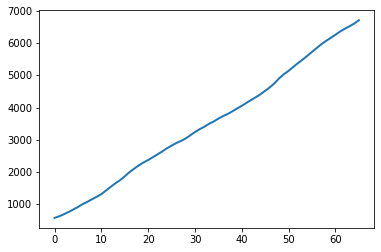

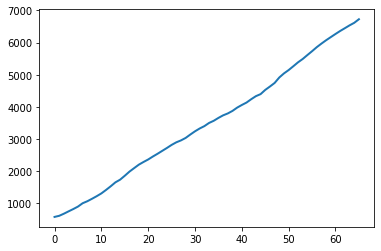

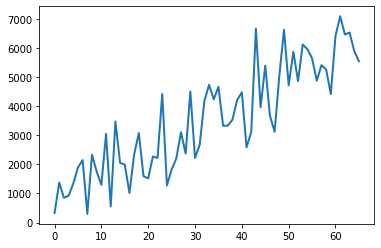

CPU times: user 5.02 s, sys: 207 ms, total: 5.23 s
Wall time: 4.97 s


In [121]:
%%time

# numpy float 출력옵션 변경
np.set_printoptions(precision=3)

print(len(data_res),'명')
ori_avg_data = np.zeros(slot_size)
for i in range(len(data_res)):
#     print(i+1,'번째 사람\n', data_res[i])
    ori_avg_data += np.array(data_res[i])
ori_avg_data /= len(data_res)
print('<ORIGINAL>\n',ori_avg_data,'\n')

# DP
dp = lap_mechanism(ori_avg_data, 0,0,len(data_res), 7000, 0.5, 1)
print('<DP>\n',dp,'\n')

# DDP
ddp = np.zeros(slot_size)
for i in range(len(data_res)):
     ddp += lap_mechanism_gamma(np.array(data_res[i]), 0, 0, len(data_res), 0.5, 1)
ddp /= len(data_res)
print('<DDP>\n',ddp,'\n')

# LDP
ldp = np.zeros(slot_size)
for i in range(len(data_res)):
#     print(i+1,'번째 사람\n', data_res[i])
     ldp += lap_mechanism(np.array(data_res[i]), 0, 0, 1, 7000, 0.5, 1)
ldp/=len(data_res)
print('<LDP>\n',ldp,'\n')


res_dir = '/home/jovyan/work/result/'
plt.rcParams["figure.figsize"] = (6,4)

plt.figure(0)
plt.plot(t, dp)
fig1 = res_dir+'00dp실험결과.png'
plt.grid(False)
plt.savefig(fig1, dpi=300, pad_inches=0)

plt.figure(1)
plt.plot(t, ddp)
fig2 = res_dir+'00ddp실험결과.png'
plt.grid(False)
plt.savefig(fig2, dpi=300, pad_inches=0)

plt.figure(2)
plt.plot(t, ldp)
fig3 = res_dir+'00ldp실험결과.png'
plt.grid(False)
plt.savefig(fig3, dpi=300, pad_inches=0)

plt.show()

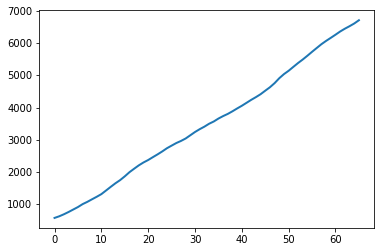

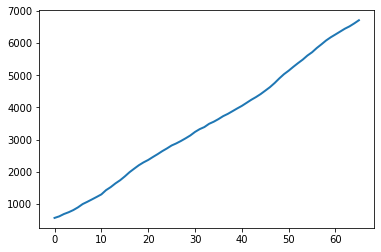

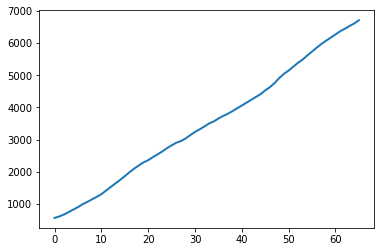

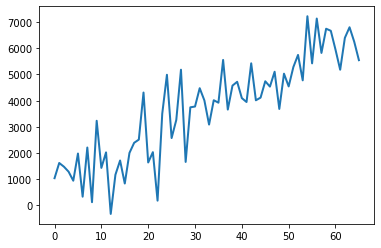

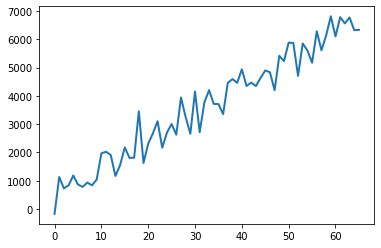

CPU times: user 9.08 s, sys: 187 ms, total: 9.27 s
Wall time: 9.03 s


In [123]:
%%time

# DDP
ddp1 = np.zeros(slot_size)
ddp2 = np.zeros(slot_size)
for i in range(len(data_res)):
    ddp1 += lap_mechanism_gamma(np.array(data_res[i]), 0, 0, len(data_res), 0.5, 1)
    ddp2 += lap_mechanism_gamma(np.array(data_res[i]), 0, 0, len(data_res), 1.0, 1)
ddp1 /= len(data_res)
ddp2 /= len(data_res)


# LDP
ldp1 = np.zeros(slot_size)
ldp2 = np.zeros(slot_size)
for i in range(len(data_res)):
    ldp1 += lap_mechanism(np.array(data_res[i]), 0, 0, 1, 7000, 0.5, 1)
    ldp2 += lap_mechanism(np.array(data_res[i]), 0, 0, 1, 7000, 1.0, 1)
ldp1/= len(data_res)
ldp2/= len(data_res)


# original
plt.figure(0)
plt.plot(t, ori_avg_data)
fig0 = res_dir+'01ori.png'
plt.grid(False)
plt.savefig(fig0, dpi=300, pad_inches=0)

# ddp 0.5
plt.figure(1)
plt.plot(t, ddp1)
fig1 = res_dir+'01ddp1.png'
plt.grid(False)
plt.savefig(fig1, dpi=300, pad_inches=0)

# ddp 1.0
plt.figure(2)
plt.plot(t, ddp2)
fig2 = res_dir+'01ddp2.png'
plt.grid(False)
plt.savefig(fig2, dpi=300, pad_inches=0)

# ldp 0.5
plt.figure(3)
plt.plot(t, ldp1)
fig3 = res_dir+'01ldp1.png'
plt.grid(False)
plt.savefig(fig3, dpi=300, pad_inches=0)

# ldp 1.0
plt.figure(4)
plt.plot(t, ldp2)
fig4 = res_dir+'01ldp2.png'
plt.grid(False)
plt.savefig(fig4, dpi=300, pad_inches=0)

plt.show()

In [15]:
print('<data count of each user>\n', user_data_count)
print()
print('<average of all user\'s step data>\n', np.round(avg_data, 2))
print()
# print('<each dataframe of all user>')
# for idx, res in enumerate(res_lst):
#     print(idx, 'th data')
#     print(res)

<data count of each user>
 {'hjstep': 133, 'kndstep': 51, 'smstep': 160, 'mrstep': 14, 'ytstep': 85}

<average of all user's step data>
 [ 564.38  614.81  678.09  749.01  825.98  902.83  993.94 1064.14 1143.92
 1221.76 1304.73 1417.39 1531.41 1641.91 1740.31 1858.23 1987.26 2095.56
 2200.73 2290.33 2366.36 2455.12 2541.48 2633.12 2732.58 2813.99 2894.24
 2959.47 3036.04 3136.92 3238.11 3325.77 3403.89 3494.28 3564.72 3656.27
 3733.11 3801.26 3882.76 3970.75 4054.34 4146.04 4238.47 4322.65 4413.82
 4523.38 4630.56 4759.27 4912.72 5039.85 5144.31 5264.78 5383.62 5493.14
 5611.16 5733.97 5853.07 5971.24 6073.6  6168.7  6265.42 6365.63 6452.57
 6530.3  6614.48 6715.62]



In [16]:
%%time

pub_key,priv_key = paillier.generate_paillier_keypair(n_length=2048) ## Generating public/private key pair

encrypted_data = list(map(lambda x: pub_key.encrypt(x), avg_data))
decrypted_data = list(map(lambda y: priv_key.decrypt(y), encrypted_data))

print(decrypted_data)

[564.3814898419864, 614.8126410835215, 678.0880361173815, 749.0135440180587, 825.979683972912, 902.8329571106095, 993.9390519187359, 1064.1422121896162, 1143.920993227991, 1221.7607223476298, 1304.7336343115123, 1417.392776523702, 1531.4085778781039, 1641.9074492099323, 1740.3069977426637, 1858.2347629796839, 1987.2550790067721, 2095.5620767494356, 2200.7313769751695, 2290.3250564334085, 2366.3566591422123, 2455.115124153499, 2541.4830699774266, 2633.117381489842, 2732.5846501128667, 2813.9909706546277, 2894.2415349887133, 2959.4740406320543, 3036.042889390519, 3136.918735891648, 3238.112866817156, 3325.767494356659, 3403.8916478555307, 3494.2799097065463, 3564.7178329571107, 3656.273137697517, 3733.110609480813, 3801.257336343115, 3882.762979683973, 3970.7516930022575, 4054.3386004514673, 4146.03611738149, 4238.467268623025, 4322.647855530474, 4413.821670428894, 4523.38374717833, 4630.564334085779, 4759.270880361174, 4912.720090293454, 5039.851015801354, 5144.306997742664, 5264.781038

# Experimental Test Code
1. 443명의 평균 데이터에 대해 3가지 privacy budget(e=0.1, 0.5, 1.0)으로 1회 실험
2. 1번 과정을 1000회 실험
3. 사용자 수와 반복 횟수를 달리하여 실험 (N=100 or 443, repeat=100 or 1000) -> 조건에 따른 노이즈 생성 정도 체크
4. N(443)명의 사용자를 그룹별로 나누고 3가지 privacy budget 조건으로 1000회 실험 -> negative한 실험결과 발생으로 사용하지 않음

number of people : 443
epsilon 0.1 : 7.142221318734783
epsilon 0.5 : 15.686825639475384
epsilon 1.0 : 0.006041768803661605


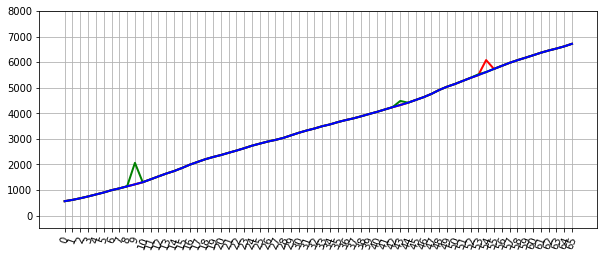

CPU times: user 527 ms, sys: 0 ns, total: 527 ms
Wall time: 509 ms


(7.142221318734783, 15.686825639475384, 0.006041768803661605)

In [18]:
%%time
# 443명의 평균 데이터를 여러가지 조건으로 비교
ori = list(np.around(avg_data))
print('number of people :', people_num)
graph_compare_with_privacy_conditions(ori, people_num, 1)

In [19]:
%%time
ep1, ep2, ep3 = 0, 0, 0
ori = list(np.around(avg_data))
repeat = 1000
for i in range(1000):
#     print('%dth test' %(i+1))
    ori = list(np.around(avg_data))
#     tmp1, tmp2, tmp3 = graph_compare_with_privacy_conditions(ori, people_num, 1)
    e1 = lap_mechanism_gamma(ori, 0, 0, people_num, 0.1, 1)
    e2 = lap_mechanism_gamma(ori, 0, 0, people_num, 0.5, 1)
    e3 = lap_mechanism_gamma(ori, 0, 0, people_num, 1.0, 1)
    
    tmp1 = sum(get_abs_diff(ori, e1))/slot_size
    tmp2 = sum(get_abs_diff(ori, e2))/slot_size
    tmp3 = sum(get_abs_diff(ori, e3))/slot_size


#     tmp1, tmp2, tmp3 = graph_compare_3(ori, people_num, 1)
    ep1 += tmp1
    ep2 += tmp2
    ep3 += tmp3

print("<<Mean Absolute Error>>")
print('number of people :', people_num)
print('1. epsilon 0.1 :', round(ep1/repeat, 2))
print('2. epsilon 0.5 :', round(ep2/repeat, 2))
print('3. epsilon 1.0 :', round(ep3/repeat, 2))
print()

<<Mean Absolute Error>>
number of people : 443
1. epsilon 0.1 : 46.72
2. epsilon 0.5 : 9.3
3. epsilon 1.0 : 4.81

CPU times: user 13.1 s, sys: 0 ns, total: 13.1 s
Wall time: 12.8 s


In [ ]:
%%time
# 노이즈 생성 정도 검증을 위한 실험
avg = 0
n = 100
repeat = 1000
file_name = 'noise_diff_repeat_' + str(n) + 'X' + str(repeat) + '.txt'
for i in range(repeat):
    print('%d번째 실험 중..' %(i+1))
    people_num=0
    index = 0
    slot_size = 66
    user_list = ['hj', 'knd', 'sm', 'mr', 'yt']
    user_data_count = {'hjstep': 0, 'kndstep': 0, 'smstep':0 , 'mrstep': 0, 'ytstep': 0}

    noise_sum = 0

    for file in file_list:
        df = pd.read_csv(file, sep=',')
        df = df.loc[df.Hour.between(10,20)]
        dates = list(df.groupby(df['Date']).size()[df.groupby(df['Date']).size()==66].index)
    #     print(dates, '<',len(dates), '>')

        for row in df.itertuples():
            if getattr(row, 'Date') not in dates:
                df.drop(row.Index, inplace=True)

        selected_df = df.groupby(df['Date']).filter(lambda y: y['Steps'].max()>4000)
        people_num+=len(selected_df.groupby(selected_df['Date']))
# 100명 or 443명 조건
#         if people_num > 100:
#             break
        for key in user_data_count.keys():
            if key in file:
                user_data_count[key] += len(selected_df.groupby(selected_df['Date']))

        slot_size = 66
        df = pd.read_csv(file, sep=',')
        df = df.loc[df.Hour.between(10,20)]
        dates = list(df.groupby(df['Date']).size()[df.groupby(df['Date']).size()==slot_size].index)
        
        for row in df.itertuples():
            if getattr(row, 'Date') not in dates:
                df.drop(row.Index, inplace=True)

        df = df.groupby(df['Date']).filter(lambda y: y['Steps'].max()>4000)
    #         print('당일 데이터가 66개인 날 중 최댓값이 4000 이상인 날:', len(df.groupby(df['Date'])), '* 66 =', len(df.groupby(df['Date']))*66,'\n')
        dates = list(df.groupby(df['Date']).size()[df.groupby(df['Date']).size()==slot_size].index)
        all_date_dict = dict()

        for date in dates:
            cur_date_list = []
            for row in df.itertuples(index=True, name='Pandas'):
                if getattr(row, 'Date')==date:
                    cur_date_list.append(getattr(row, 'Steps'))
            all_date_dict[date] = cur_date_list
            noise_sum += sum(lap_mechanism_gamma(all_date_dict[date], 0, 0, people_num, 1.0), 1) - sum(all_date_dict[date])
    write_result_to_txt(((abs(lap(0,(7000)/(1.0/slot_size)) - noise_sum))), file_name)
print('실험 완료')

1번째 실험 중..
2번째 실험 중..
3번째 실험 중..
4번째 실험 중..


In [58]:
%%time

ss=66
g=6
group_avg_lst = [[0 for i in range(ss//g)] for j in range(g)]

# for idx, group in enumerate(group_avg_lst):
#     print('Group', idx+1, '-', group)
# print()

for x in range(len(res_lst)):
    for i in range(1, g+1):
        for j in range(i, ss+1, g):
            group_avg_lst[i-1][(j-1)//6] += list(res_lst[x]['Steps'].values)[j-1]
#             print(i-1, (j-1)//6, x, j-1,list(res_lst[x]['Steps'].values)[j-1])
#             print(list(res_lst[x]['Steps'].values)[j-1], end=' ')

for idx, group in enumerate(group_avg_lst):
    group_avg_lst[idx] = np.round((np.array(group)/len(res_lst)), 2)

# 3 * 6 matrix (3 epsilon and 6 group)
group_avg_result = [[0 for i in range(3)] for j in range(g)]
repeat = 1000

print('Epsilon : 0.1\t 0.5\t1.0')

for i in range(repeat):
#     print('%d번째 실험' %(i+1))
    for idx, group in enumerate(group_avg_lst):
        group_avg_result[idx][0] += np.round(abs((sum(list(np.round(lap_mechanism_gamma(group, 0, 0, len(res_lst)/g, 0.1, 2), 2)))) - sum(list(group))), 2)
        group_avg_result[idx][1] += np.round(abs((sum(list(np.round(lap_mechanism_gamma(group, 0, 0, len(res_lst)/g, 0.5, 2), 2)))) - sum(list(group))), 2)
        group_avg_result[idx][2] += np.round(abs((sum(list(np.round(lap_mechanism_gamma(group, 0, 0, len(res_lst)/g, 1.0, 2), 2)))) - sum(list(group))), 2)

for idx, group in enumerate(group_avg_result):
    print('Group', idx+1, end=' : ')
    print(np.round(np.array(group)/repeat, 2))

# print('Epsilon : 0.1\t\t0.5\t\t1.0')    
# for idx, group in enumerate(group_avg_lst):
#     print('Group', idx+1, end=' : ')
# #     print('original data :', list(group))
# #     print('  noised data :', list(np.round(gamma_test2(group, 0, 0, len(res_lst)/g, 0.1), 2)))
#     print(np.round((sum(list(np.round(lap_mechanism_gamma(group, 0, 0, len(res_lst)/g, 0.1, 2), 2)))) - sum(list(group))print(np.round(, 2), end='\t')
#     print(np.round((sum(list(np.round(lap_mechanism_gamma(group, 0, 0, len(res_lst)/g, 0.5, 2), 2)))) - sum(list(group)), 2), end='\t')
#     print(np.round((sum(list(np.round(lap_mechanism_gamma(group, 0, 0, len(res_lst)/g, 1.0, 2), 2)))) - sum(list(group)), 2))
#     sensitivity, N, epsilon, slot_size, group

Epsilon : 0.1	 0.5	1.0
Group 1 : [16182.9   3164.56  1459.  ]
Group 2 : [17073.56  3034.67  1708.36]
Group 3 : [15525.14  2900.71  1387.22]
Group 4 : [15977.08  2946.27  1600.12]
Group 5 : [16626.42  2873.34  1429.83]
Group 6 : [15341.71  2957.24  1513.33]
CPU times: user 9.7 s, sys: 51.7 ms, total: 9.75 s
Wall time: 9.67 s


# Unit Test Code
- 유닛 테스트를 위해 하나의 파일로만 코드 실행

    1. 당일 데이터가 66개인 날 중 데이터의 최댓값이 4000 이상인 날<br>
    2. 1번 과정에서 뽑은 데이터 프레임을 히스토그램 형태로 만들어보기<br>
    3. mongoDB 연결 후 데이터 삽입 테스트<br>
    4. Paillier Homomorphic Encryption Scheme를 통한 암호화 테스트<br>
    5. 데이터 프레임을 iterate하는 여러가지 방법<br>
    6. 데이터 복제<br>

In [150]:
%%time
# 1. test with one file

slot_size = 66

# df = pd.read_csv(file_list[0], sep=',', index_col='Datetime', parse_dates=True)
df = pd.read_csv(file_list[0], sep=',')
df = df.loc[df.Hour.between(10,20)]

dates = list(df.groupby(df['Date']).size()[df.groupby(df['Date']).size()==slot_size].index)
print('당일 데이터 갯수가 66개인 날 :', len(dates))

for row in df.itertuples():
    if getattr(row, 'Date') not in dates:
        df.drop(row.Index, inplace=True)
    
df = df.groupby(df['Date']).filter(lambda y: y['Steps'].max()>4000)
print('당일 데이터가 66개인 날 중 최댓값이 4000 이상인 날:', len(df.groupby(df['Date'])), '* 66 =', len(df.groupby(df['Date']))*66,'\n')
dates = list(df.groupby(df['Date']).size()[df.groupby(df['Date']).size()==slot_size].index)
# df

# df.set_index(df['Datetime'].astype('datetime64[ns]'), inplace=True)
# df['Steps'].resample(rule='10T').max()

df[['Steps', 'Timestamp', 'Date', 'Datetime', 'Hour']]
header = ['Steps', 'Timestamp', 'Date', 'Datetime', 'Hour']
# df[header]

당일 데이터 갯수가 66개인 날 : 20
당일 데이터가 66개인 날 중 최댓값이 4000 이상인 날: 9 * 66 = 594 

CPU times: user 70.5 ms, sys: 30 µs, total: 70.5 ms
Wall time: 69.1 ms


[1.25766198e-34 0.00000000e+00 1.64459379e-09 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.86668500e-11 5.09073675e+01 0.00000000e+00]


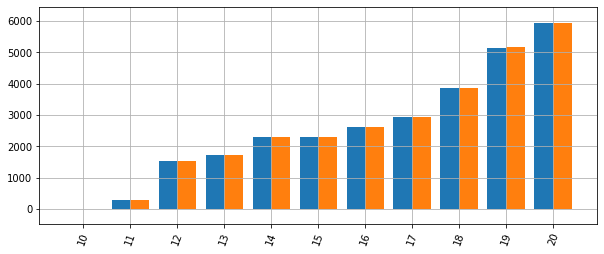

CPU times: user 159 ms, sys: 37 µs, total: 159 ms
Wall time: 157 ms


In [366]:
%%time
# 2. test with one file - histogram generate

histogram_generate(df)

# Issue
몽고디비의 호스트 이름을 서버 ip주소로 할 시 Server Selection TimeOut Error가 발생하는데 이는 호스트 이름을 몽고 클라이언트가 제대로 인식하지 못하는 문제 발생
# 해결
mongodb://117.16.43.107:27017/ -> mongodb://localhost:27017/ 로 해결

In [25]:
%%time
import pymongo
from pymongo import MongoClient
import pandas as pd

# Making a Connection with MongoClient
# eHealthdb.step_data
client = MongoClient("mongodb://localhost:27017/")
# database
db = client["eHealthdb"]
# collection
step_data_collection = db["step_data"]
# data insert
print('Data Inserting..')
step_data_collection.insert_many(list(df.to_dict(orient='records')))

Data Inserting..
CPU times: user 237 ms, sys: 0 ns, total: 237 ms
Wall time: 392 ms


In [444]:
%%time
print('==  Paillier Homomorphic Encryption Scheme  ==\n\n>> Generating Ciphertext..')
pa = Paillier()
pa.setKey(pa.pub_key, pa.priv_key)
encrypted_data_list = pa.enc(lap_mechanism_gamma(all_date_dict[dates[1]], 0, 0, len(dates), 1.0, 1))
# print('>> Encrypt Complete.\n>> Please Wait for function check..')
# pa.func_chk(lap_mechanism_gamma(all_date_dict[dates[1]]))
# print('>> Function Check Complete.')
# for data in encrypted_data_list:
#     print(pa.priv_key.decrypt(data))
# graph_compare_with_noisy_data(all_date_dict[dates[1]], ), 1)

==  Paillier Homomorphic Encryption Scheme  ==

>> Generating Ciphertext..
CPU times: user 5.68 s, sys: 0 ns, total: 5.68 s
Wall time: 5.67 s


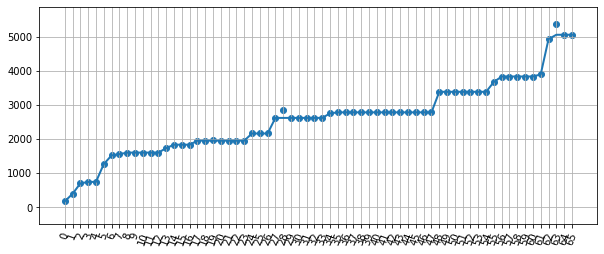

In [468]:
graph_compare_with_noisy_data(all_date_dict[dates[1]], lap_mechanism_gamma(all_date_dict[dates[1]], 0, 0, 443, 1.0, 1), 1)

In [ ]:
# #various method to iterate dataframe
# #1
# for i in range(len(df)):
#     for date in dates:
#         cur_date = date
#         if df.iloc[i, 2] == cur_date:
#             pass
#             #날짜가 같을 동안 blahblah
#         else:
#             cur_date = df.iloc[i, 2]
#             print('date changed!')
#         print(date)
# #2
# for row_dict in df.to_dict(orient='records'):
#     for date in dates:
#         cur_date = date
#         cur_date_list = []
#         if row_dict['Date'] == cur_date:
#             for i in range(slot_size):
#                 cur_date_list.append(row_dict['Steps'])
#         else:
#             cur_date = row_dict['Date']
#             print('date changed')
#         print(date)
# #3
# for row in df.itertuples(index=False, name='Pandas'):
#     cur_date_dict=dict()
#     for date in dates:
#         cur_date = date
#         if getattr(row, 'Date') == cur_date:
#             pass
#         else:
#             cur_date = getattr(row, 'Date')
#             for i in range(slot_size):
#                 cur_date_dict[i] = getattr(row, 'Steps')
#             print(cur_date_dict)
#             print('date changed')
#         print(date)

In [386]:
# 3. test with one file
# #5배 복제
# duplicated_df = pd.DataFrame(columns=['Steps', 'Timestamp', 'Date', 'Datetime', 'Hour'])

# for i in range(5):
#     duplicated_df = duplicated_df.append(df, ignore_index=True)

# duplicated_df

# # 전체 날짜 평균 데이터 구하는 코드
# avg_data = np.zeros(slot_size)
# duplicated_df.index = np.arange(1, len(duplicated_df)+1)

        
# # for i in range(len(avg_data)):
# #     print(i)    
# for i in range(slot_size):
#     for j in range(len(duplicated_df)//slot_size):
# #         print(i+j*66, end=' ')
#         avg_data[i] += duplicated_df.iloc[i+(j*slot_size)]['Steps']

# avg_result = avg_data / slot_size
# del avg_data
# arr = np.rint(avg_result).astype('int32')

# plt.figure(1)
# # plt.ylim(-50, 50)
# plt.plot(arr, '-b')

# plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'index'